In [ ]:
!pip install tinygrad pandas numpy matplotlib tqdm

#### Import libraries

In [1]:
# import libraries

from tinygrad.tensor import Tensor
from tinygrad import optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

#### Load and visualize train data

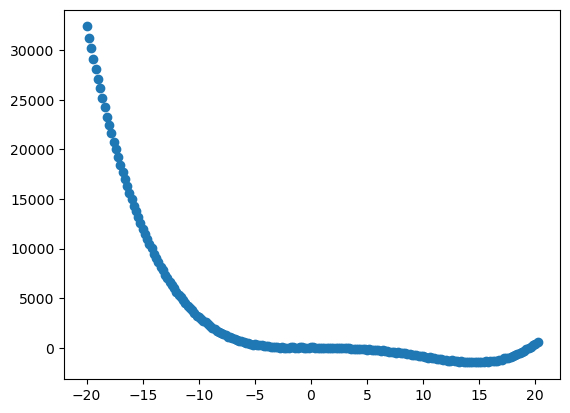

In [2]:
#load training data
train = pd.read_csv('data_train.csv')

#plot the data for visualization
plt.scatter(train['x'], train['y'])
plt.show()

#### Data preprocessing
Since we have train data of values ranging up to 30,000, we have to scale the data such that the model will not reproduce
large loss values. To do this, we will standardize the data using its mean and standard deviation.

In [3]:
def mean(data):
    # get mean of the data
    return sum(data)/len(data)

def std(data):
    # get standard deviation of the data
    mu = mean(data)
    return np.sqrt(sum([(x-mu)**2 for x in data])/(len(data)-1))

def standardize(data):
    # standardize the data using the mean and standard deviation
    mu = mean(data)
    sigma = std(data)
    return [(x-mu)/sigma for x in data]

After training the model using the scaled data, we will return the values of the train data to original scale. The weights and bias will also be rescaled accordingly so that we can determine the original parameters for the given polynomial.

In [4]:
def return_to_original(data, mu, sigma):
    # return the standardized data to its original form
    return [x*sigma+mu for x in data]

def rescale_wandb(wandb, x_mu, x_sigma, y_mu, y_sigma, degree):
    # rescale the weights and bias so that they can be used to predict the originally scaled data   
    weights_rescaled = np.zeros(degree)
    w = wandb[0].data
    bias_rescaled = wandb[1].data[0]

    for i in range(1, degree+1):
        for j in range(i):
            nth_term = (w[degree-i]/x_sigma**i) * (np.math.factorial(i)/(np.math.factorial(i-j)*np.math.factorial(j))) * x_mu**(j) * (-1)**(j)
            weights_rescaled[i-j-1] += nth_term
        bias_rescaled += x_mu**i * (-1)**(i) * (w[degree-i]/x_sigma**i)

    weights_rescaled = np.array(weights_rescaled*y_sigma)
    weights_rescaled = weights_rescaled[::-1]
    bias_rescaled = (bias_rescaled*y_sigma) + y_mu

    return weights_rescaled, bias_rescaled

#### More functions for training
Here, we created functions that will be used to train the model. The functions are:
- 'predict_data': This function will be used to predict the values of the train data given the weights and bias of the model.

- 'loss_fn': This function will be used to calculate the loss of the model given the predicted values and the actual values of the train data. The loss function used here is the mean squared error.

- 'calc_grad': This function will be used to calculate the gradients of the weights and bias of the model given the predicted values and the actual values of the train data. The gradients will be used to update the weights and bias of the model.

In [5]:
def predict_data(wandb, x, degree):
    # predict the output given the weights and bias
    w = wandb[0].data
    b = wandb[1].data
    y_pred = np.zeros(len(x))
    for i in range(len(x)):
        for j in range(degree):
            y_pred[i] += w[j]*x[i]**(degree-j)
        y_pred[i] += b
    return y_pred

def loss_fn(y_pred, y_true):
    # calculate the loss
    return ((y_pred - y_true)**2).mean()

def calc_grad(x, y, w, b, degree):
    # calculate the gradient of the loss function
    dl_wb = np.zeros(degree+1)
    y_pred = predict_data([w, b], x, degree)
    for i in range(degree):
        dl_wb[i] = (2*(y_pred-y)*x**(degree-i)).mean()
    dl_wb[degree] = (2*(y_pred-y)).mean()
    return dl_wb

#### Dividing the train data
We will divide the train data into two sets: train set and validation set. The train set will be used to train the model while the validation set will be used to validate the model. The validation set will be used to determine the best parameters or coefficients of the polynomial.

In [6]:
def split_indices(data, k):
    # split the data into k folds where the first fold is data with indices 0, k, 2k, ..., and so on
    folds = []
    for i in range(k):
        fold = []
        for j in range(len(data)):
            if j%k == i:
                fold.append(j)
        fold = np.array(fold)
        folds.append(fold)
    return folds

def split_data(x_data, y_data, fold):

    x_copy = x_data.copy()
    y_copy = y_data.copy()
    x_train = np.delete(x_copy, fold) # delete the fold from the data to be used for training
    y_train = np.delete(y_copy, fold)
    x_validation = x_copy[fold] # use the fold for validation
    y_validation = y_copy[fold]

    x_train = Tensor(x_train)
    y_train = Tensor(y_train)
    x_validation = Tensor(x_validation)
    y_validation = Tensor(y_validation)

    return x_train, y_train, x_validation, y_validation
    

#### Train the model
Now, we train the model using SGD optimizer. 

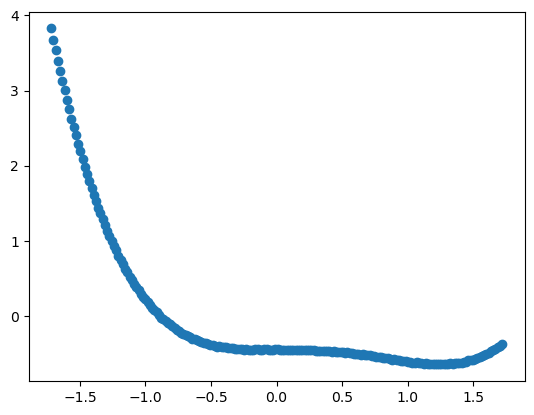

In [7]:
# preprocess data

# get mean and standard deviation of x and y
x_mean = mean(train['x'])
x_std = std(train['x'])
y_mean = mean(train['y'])
y_std = std(train['y'])
# standardize x and y
x = standardize(train['x'])
y = standardize(train['y'])

# plot the standardized data for visualization
plt.scatter(x, y)
plt.show()

In [8]:
# convert to tinygrad tensors
x = Tensor(x)
y = Tensor(y)

In [9]:
# set hyperparameters
epochs = 1000 # number of epochs
lr = 0.01 # learning rate
k = 5 # assign number of folds
batch_size = 32 # assign batch size

In [19]:
losses = [] # store training losses
val_losses = [] # store validation losses
params = [] # store parameters

# split data into 5 folds
folds = split_indices(x.data, k)

# train model with k-fold cross validation
for i in range(k):
    x_train, y_train, x_validation, y_validation = split_data(x.data, y.data, folds[i])
    degree = i+1
    loss_list = []
    # initialize parameters
    w = Tensor(np.random.randn(degree)) # k+1 weights
    b = Tensor(np.random.randn(1)) # 1 bias term
    # initialize optimizer
    opt = optim.SGD([w, b], lr=lr)

    # train model
    for epoch in tqdm(range(epochs)):
        idx = np.random.permutation(x_train.shape[0]) # shuffle data
        batches = np.array_split(idx, len(idx)//batch_size) # split data into batches
    
        # train model on batches 
        for batch in batches:
            xb = x_train.data[batch]
            yb = y_train.data[batch]

            y_pred = predict_data([w, b], xb, degree) # make predictions
            loss = loss_fn(y_pred, yb) # calculate loss
            grad = calc_grad(xb, yb, w, b, degree) # calculate gradients
            opt.params[0].grad = np.array(grad[0:len(grad)-1]) # update gradients of weights
            opt.params[1].grad = np.array(grad[len(grad)-1]) # update gradients of bias term
            opt.step() # update parameters
            loss_list.append(loss) # store loss

    #validate model
    y_pred = predict_data([w, b], x_validation.data, degree)
    val_loss = loss_fn(y_pred, y_validation.data)
    val_losses.append(val_loss)
    losses.append(loss_list)

    #save parameters
    params.append([w.data, b.data])

100%|██████████| 1000/1000 [00:05<00:00, 177.79it/s]


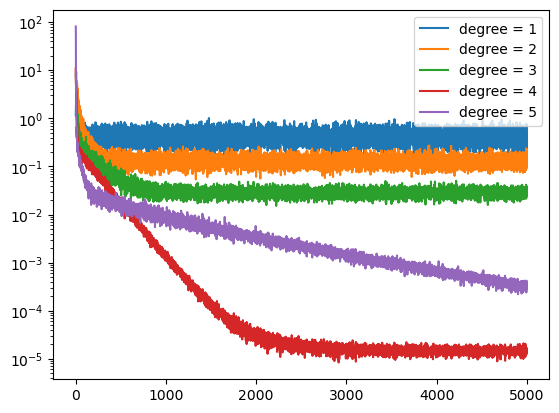

In [20]:
# plot training losses
for i in range(k):
    plt.plot(losses[i], label='degree = ' + str(i+1))
plt.yscale('log')
plt.legend()
plt.show()

In [21]:
for i in range(k):
    print('Validation loss for fold', i+1, ':', val_losses[i])
    print('Parameters for fold', i+1, ':', params[i])

best_params = params[np.argmin(val_losses)] # get parameters with the lowest validation loss
best_degree = np.argmin(val_losses)+1 # get degree of parameters with the lowest validation loss
print('\nMinimum validation loss:', np.min(val_losses))
print('Degree with minimum loss:', best_degree)
print('Best parameters:', best_params)

Validation loss for fold 1 : 0.5221538819935037
Parameters for fold 1 : [array([-0.72861891]), array([-0.0077898])]
Validation loss for fold 2 : 0.13879312579165617
Parameters for fold 2 : [array([ 0.63696389, -0.7345765 ]), array([-0.63220076])]
Validation loss for fold 3 : 0.025808096672174867
Parameters for fold 3 : [array([-0.40971897,  0.64053443, -0.00184209]), array([-0.63666263])]
Validation loss for fold 4 : 1.6908360655642742e-05
Parameters for fold 4 : [array([ 0.24655979, -0.41282272,  0.00622446,  0.00163701]), array([-0.44543327])]
Validation loss for fold 5 : 0.00025792385116703016
Parameters for fold 5 : [array([ 0.02688721,  0.24770002, -0.50988196,  0.0033579 ,  0.07378295]), array([-0.4446109])]

Minimum validation loss: 1.6908360655642742e-05
Degree with minimum loss: 4
Best parameters: [array([ 0.24655979, -0.41282272,  0.00622446,  0.00163701]), array([-0.44543327])]


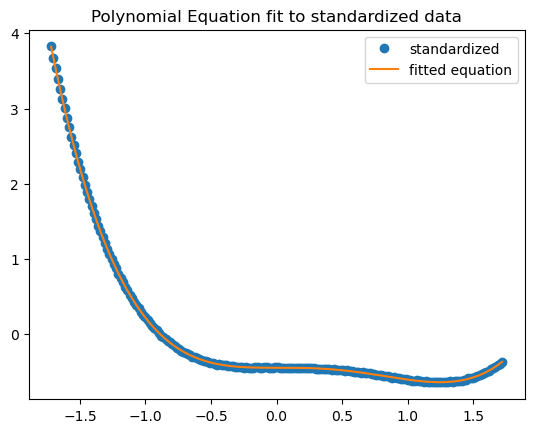

In [22]:
# make predictions on the standardized training data
y_pred = predict_data(best_params, x.data, best_degree)

# plot the data
plt.plot(x.data, y.data, 'o')
plt.plot(x.data, y_pred)
plt.title('Polynomial Equation fit to standardized data')
plt.legend(['standardized', 'fitted equation'])
plt.show()

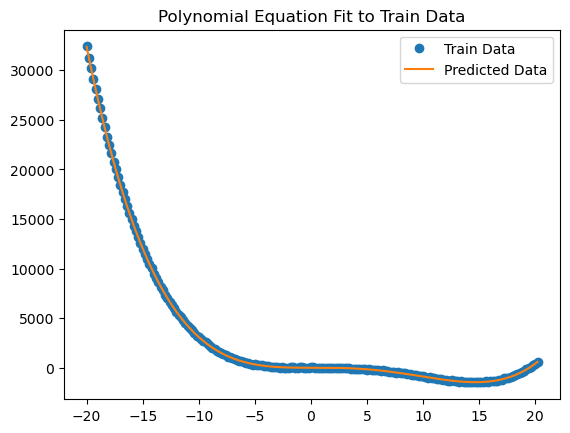

In [23]:
#return data to original scale
x_orig = return_to_original(x.data, x_mean, x_std)
y_orig = return_to_original(y.data, y_mean, y_std)
x_orig = Tensor(x_orig)
y_orig = Tensor(y_orig)

#rescale parameters for original data
best_params_rescaled = rescale_wandb(best_params, x_mean, x_std, y_mean, y_std, best_degree)
best_params_rescaled = [Tensor(best_params_rescaled[0]), Tensor([best_params_rescaled[1]])]

#make predictions on original data
y_pred_rescaled = predict_data(best_params_rescaled, x_orig.data, best_degree)

#plot the data
plt.plot(x_orig.data, y_orig.data, 'o')
plt.plot(x_orig.data, y_pred_rescaled)
plt.title('Polynomial Equation Fit to Train Data')
plt.legend(['Train Data', 'Predicted Data'])
plt.show()

In [24]:
#print the parameters
print('Weights:', best_params_rescaled[0].data)
print('Bias:', best_params_rescaled[1].data[0])
equation = 'y = '
for i in range(best_degree):
    equation += str(best_params_rescaled[0].data[i]) + 'x^' + str(best_degree-i) + ' + '
equation += str(best_params_rescaled[1].data[0])
print('Polynomial equation:', equation)

Weights: [ 0.10009235 -1.99935665  0.9391891   0.93372995]
Bias: 8.385382
Polynomial equation: y = 0.10009235244586456x^4 + -1.9993566504581637x^3 + 0.9391891019091789x^2 + 0.933729947768291x^1 + 8.385382


In [25]:
#get rmse of training data
rmse_train = np.sqrt(np.mean((y_pred_rescaled - y_orig.data)**2))
print('RMSE on training data:', rmse_train)

RMSE on training data: 29.40858534417395


#### Check performance on test set

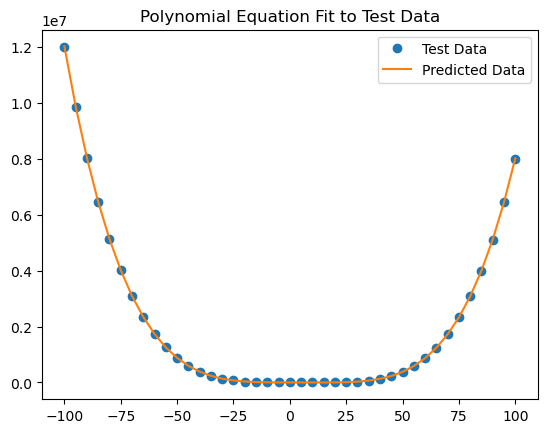

In [26]:
# open the test data
test = pd.read_csv('data_test.csv')

#create x and y test data
x_test = test['x']
y_test = test['y']

#predict y values
y_pred_test = predict_data(best_params_rescaled, x_test, best_degree)

#plot the data
plt.plot(x_test, y_test, 'o')
plt.plot(x_test, y_pred_test)
plt.title('Polynomial Equation Fit to Test Data')
plt.legend(['Test Data', 'Predicted Data'])
plt.show()

In [27]:
#compute RMSE on test data
rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('RMSE on test data:', rmse_test)

RMSE on test data: 3127.6575167319093
